## Data Loading

In [3]:
# Step 1: Load and Explore EEG Pain Dataset segments_raw_1000hz_v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# Set dataset root path
root = '/EEG Pain Estimation/data'

# --- Load index.csv ---
index_path = f'{root}/index.csv'
if not os.path.exists(index_path):
    raise FileNotFoundError(f"index.csv not found in {root}")

index_df = pd.read_csv(index_path)
print("Total epochs:", len(index_df))
print(index_df.head())

# --- Check and clean invalid / rejected entries ---
if 'reject_flag' in index_df.columns:
    print(f"Found 'reject_flag' column. Removing rejected epochs...")
    clean_df = index_df[index_df['reject_flag'] == False].copy()
else:
    print("'reject_flag' column not found — using full dataset.")
    clean_df = index_df.copy()

if len(clean_df) == 0:
    print("No valid rows found after filtering. Reverting to full dataset.")
    clean_df = index_df.copy()

print("Clean epochs after filtering:", len(clean_df))

Total epochs: 80282
                               path participant session stimulus_code  \
0   sub-001_ses-1_S18_85554_erp.npz     sub-001   ses-1          S 18   
1  sub-001_ses-1_S18_111637_erp.npz     sub-001   ses-1          S 18   
2  sub-001_ses-1_S18_258152_erp.npz     sub-001   ses-1          S 18   
3  sub-001_ses-1_S18_374867_erp.npz     sub-001   ses-1          S 18   
4  sub-001_ses-1_S18_491584_erp.npz     sub-001   ses-1          S 18   

  stimulus_category  pain_rating rating_bin window   sfreq  n_channels  \
0       Non-painful          0.2       none    erp  1000.0          64   
1       Non-painful          0.1       none    erp  1000.0          64   
2       Non-painful          0.0       none    erp  1000.0          64   
3       Non-painful          0.0       none    erp  1000.0          64   
4       Non-painful          0.3       none    erp  1000.0          64   

   n_times  reject_flag  
0     1001        False  
1     1001        False  
2     1001        

In [11]:
index_df.head()

,path,participant,session,stimulus_code,stimulus_category,pain_rating,rating_bin,window,sfreq,n_channels,n_times,reject_flag
0,sub-001_ses-1_S18_85554_erp.npz,sub-001,ses-1,S 18,Non-painful,0.2,none,erp,1000.0,64,1001,False
1,sub-001_ses-1_S18_111637_erp.npz,sub-001,ses-1,S 18,Non-painful,0.1,none,erp,1000.0,64,1001,False
2,sub-001_ses-1_S18_258152_erp.npz,sub-001,ses-1,S 18,Non-painful,0.0,none,erp,1000.0,64,1001,False
3,sub-001_ses-1_S18_374867_erp.npz,sub-001,ses-1,S 18,Non-painful,0.0,none,erp,1000.0,64,1001,False
4,sub-001_ses-1_S18_491584_erp.npz,sub-001,ses-1,S 18,Non-painful,0.3,none,erp,1000.0,64,1001,False


In [18]:
index_df["window"].unique()

array(['erp', 'post', 'baseline'], dtype=object)

In [12]:
index_df.shape

(80282, 12)

In [4]:
# What does stimulus category mean?
# Unique: ['Non-painful', 'Painful', 'High Pain']
index_df['pain_rating'].unique()

array([ 0.2,  0.1,  0. ,  0.3,  0.4,  1. ,  0.8,  0.7,  1.1,  0.9,  1.5,
        1.6,  1.2,  2.1,  2. ,  5.5,  3.5,  5.7,  5.2,  3.8,  1.9,  3.3,
        5.1,  9.7,  7.7,  7.8,  8.5,  8.6, 10. ,  7. ,  1.3,  1.4,  2.8,
        2.2,  3. ,  4.1,  4.8,  4.3,  5.4,  3.7,  6.2,  9.6,  6.1,  9.3,
        7.2,  8.1,  1.7,  0.5,  1.8,  2.3,  2.5,  2.9,  4.7,  3.2,  6.4,
        6.3,  8.3,  6.7,  8.2,  8. ,  9.9,  8.8,  8.9,  2.4,  4.2,  4.6,
        4.5,  7.1,  9.4,  7.4,  7.3,  5.9,  2.7,  9.1,  9.2,  3.1,  6.8,
        3.4,  6. ,  8.7,  9. ,  2.6,  3.9,  7.5,  7.6,  0.6,  5.8,  4. ,
        3.6,  5.3,  6.5,  8.4,  5.6,  4.4,  4.9,  9.8,  6.9,  5. ,  7.9,
        6.6,  9.5])

## Data Visualization and analysis

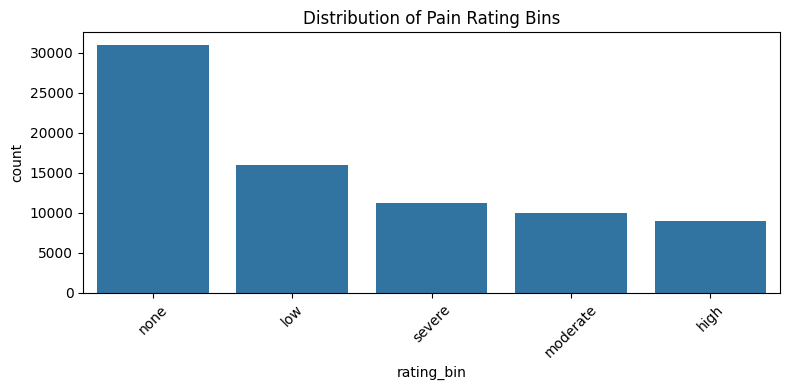

In [5]:
# --- Distribution of pain categories ---
plt.figure(figsize=(8, 4))
sns.countplot(data=clean_df, x='rating_bin', order=clean_df['rating_bin'].value_counts().index)
plt.title("Distribution of Pain Rating Bins")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

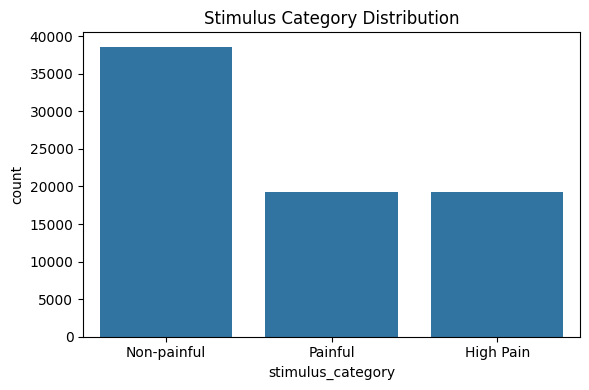

In [6]:
# --- Distribution of stimulus types ---
if 'stimulus_category' in clean_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=clean_df, x='stimulus_category')
    plt.title("Stimulus Category Distribution")
    plt.tight_layout()
    plt.show()
else:
    print("'stimulus_category' column not found in CSV")


In [7]:

example = clean_df.sample(1, random_state=42).iloc[0]

npz_path = f"{root}/npz/{example['path']}"
if not os.path.exists(npz_path):
    raise FileNotFoundError(f"EEG .npz file not found: {npz_path}")

npz = np.load(npz_path, allow_pickle=True)
X = npz['X']  # shape: (channels, time)
ch_names = npz['ch_names']

print(f"Example EEG shape: {X.shape} (channels × time)")
print(f"Channels available: {len(ch_names)}")

Example EEG shape: (64, 1001) (channels × time)
Channels available: 64


## Data extraction

In [8]:
import os
from tqdm import tqdm
import numpy as np
from scipy.signal import stft
from collections import Counter

fs = 1000
nperseg = 256 
noverlap = 128

def compute_spectrogram(X, fs=1000, nperseg=256, noverlap=128):
    specs = []
    for ch in range(X.shape[0]):
        f, t, Zxx= stft(X[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        specs.append(np.abs(Zxx))
    return np.stack(specs, axis=0)

features, labels, ch_counts = [], [], []

# Pass 1 — find most common channel count
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Scanning channels"):
    npz_path = os.path.join(root, 'npz', row['path'])
    if not os.path.exists(npz_path):
        continue
    npz = np.load(npz_path, allow_pickle=True)
    ch_counts.append(npz['X'].shape[0])

most_common_channels = Counter(ch_counts).most_common(1)[0][0]
print(f"Most common channel count: {most_common_channels}")

# Pass 2 — extract features only from those epochs
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Extracting features"):
    npz_path = os.path.join(root, 'npz', row['path'])
    if not os.path.exists(npz_path):
        continue
    npz = np.load(npz_path, allow_pickle=True)
    X = npz['X']

    # Skip files with mismatched channel count
    if X.shape[0] != most_common_channels:
        continue

    spec = compute_spectrogram(X, fs, nperseg, noverlap)
    mean_feat = np.mean(spec, axis=(1, 2))
    std_feat = np.std(spec, axis=(1, 2))
    feat = np.concatenate([mean_feat, std_feat])
    features.append(feat)
    labels.append(row['rating_bin'])

# Convert to arrays safely
X_features = np.vstack(features)
y_labels = np.array(labels)

print(" Feature matrix shape:", X_features.shape)
print(" Labels:", np.unique(y_labels, return_counts=True))

Scanning channels: 100%|██████████| 77190/77190 [02:30<00:00, 513.39it/s]


Most common channel count: 64


Extracting features: 100%|██████████| 77190/77190 [06:16<00:00, 204.86it/s]

 Feature matrix shape: (75700, 128)
 Labels: (array(['high', 'low', 'moderate', 'none', 'severe'], dtype='<U8'), array([ 8776, 15687,  9835, 30391, 11011]))


## Train Classical Models

In [9]:
# STEP 4: Train and Evaluate ML Models-
# 70-10-20
# Subject level separation splitting also.
# Regression first - ML (Binary - remove none) - Pain/Non pain
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Encode Labels (convert text to numeric)
le = LabelEncoder()
y_labels_enc = le.fit_transform(y_labels)

print("Encoded label mapping:")
for i, cls in enumerate(le.classes_):
    print(f"  {i}: {cls}")

# Handle class imbalance using SMOTE (optional)
print("\nApplying SMOTE to balance classes...")
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_features, y_labels_enc)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=42, n_jobs=-1
    ),
    "SVM": SVC(kernel="rbf", C=2, gamma="scale"),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
}

# Train and evaluate
for name, model in models.items():
    print(f"\n Training {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Convert numeric predictions back to string labels for readability
    y_true = le.inverse_transform(y_test)
    y_pred = le.inverse_transform(preds)
 
    print(f"\n Results for {name}:")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

Encoded label mapping:
  0: high
  1: low
  2: moderate
  3: none
  4: severe

Applying SMOTE to balance classes...

 Training RandomForest ...

 Results for RandomForest:
              precision    recall  f1-score   support

        high      0.784     0.828     0.805      6078
         low      0.682     0.659     0.670      6078
    moderate      0.720     0.811     0.763      6078
        none      0.576     0.475     0.521      6079
      severe      0.765     0.785     0.775      6078

    accuracy                          0.712     30391
   macro avg      0.705     0.712     0.707     30391
weighted avg      0.705     0.712     0.707     30391

Confusion Matrix:
[[5030  247  256  296  249]
 [ 316 4005  469  948  340]
 [ 221  232 4930  447  248]
 [ 560 1109  892 2888  630]
 [ 286  279  302  437 4774]]

 Training SVM ...

 Results for SVM:
              precision    recall  f1-score   support

        high      0.290     0.357     0.320      6078
         low      0.333     0.175

In [10]:
"""
train_ds = EEGDataset(meta_df.sample(2000, random_state=42), root=ROOT, label_encoder=le_full)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

for X, y in train_loader:
    print("Batch X:", X.shape)  # Expect [32, 64, 1001]
    print("Batch y:", y.shape)
    break
"""

'\ntrain_ds = EEGDataset(meta_df.sample(2000, random_state=42), root=ROOT, label_encoder=le_full)\ntrain_loader = DataLoader(train_ds, batch_size=32, shuffle=True)\n\nfor X, y in train_loader:\n    print("Batch X:", X.shape)  # Expect [32, 64, 1001]\n    print("Batch y:", y.shape)\n    break\n'